# **10.1 Introduction to Stereo vision**

As we stated in the previous notebooks, using a single image is not enough to infer 3D information of the scene, since all the 3D points lying on the ray starting from the camera's optical center and passing through a certain pixel **project to that very same pixel**.

*Stereovision* is the process of **extracting 3D information** (depth, shape, size and location of objects in space) **from multiple images of a scene**.

In these two images you can see part of the Red Square in Moscow, but seen from **slightly different points of view**:
<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/stereo.jpg" width="600" /></center>

Although the difference is subtle, it is enough to provide information about what elements are closer to the camera and, in some sense, what are the sizes of the objects in the scene.

As we will further describe later, we will denote by **disparity** the distance in the image between two corresponding points in the left and the right image. This value of the disparity for a certain point **is inversely proportional to the distance from the camera to the point** (i.e. the depth of the point).

In this notebook, we will introduce how stereo vision works, and their problems:

- Introduction to scene reconstruction
- Triangulation and disparity
- Constraints for correspondences

**This notebook only contains <font color=green>1 assignment</font>**



## **Problem context - Scene reconstruction using Stereo Vision**

Having two separated cameras, we can reconstruct a scene (obtain a real size 3D map) knowing the **disparity** of every point and the camera intrinsic parameters:

<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/stereo-reconstruction.png" width="600" /></center>$\\[5pt]$

If you look carefully you will note that these two images shows some black zones at the edges. That is because the images have been processed **in order to remove the distortion** (recall from the previous notebook), and that is because the stereo equations only works in undistorted images, hence the importance of calibrating the cameras we are using for this task.

In this particular case, a **dense stereo** approach has been followed in where the depth has been computed **for every single pixel** in the images so that the 3D reconstruction is achieved for the majority of the scene. Alternatively, a **sparse stereo** approach only finds the depth in certain points (keypoints, for example) which might be enough for certain applications (as robot navigation, for instance).

For this notebook we will use knowledge from other parts of the course such as keypoint detection and matching, using the camera model, or camera calibration.

Our task in this chapter is to understand all the theory behind stereo vision in order to **generate 3D maps** (even for photos taken with our mobile phone).

Just two last details about scene reconstruction:
- it does not require two cameras, but **two different views of the scene**.
- it generalizes to the use of more than two cameras/views, that is, **it is not restricted to just two views**.

Now, let's begin!

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
from mpl_toolkits.mplot3d import Axes3D

images_path = '/gdrive/My Drive/Colab Notebooks/Chapter 10. Stereo vision/images/'

## **10.1.1 Introduction to scene reconstruction**

Having multiple images of a scene, it is possible to **create a 3D map of that scene using stereo vision** techniques. As said before, this does not require two cameras, **but two different views of the scene**. In this sense, we have different possibilities:

- **StereoVision system** (the standard one)
    - Two cameras
    - Images taken simultaneously
    - The relative pose of the cameras is **known**
    
<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/stereovision.jpg" width="400" /></center>

- **Structure-from-Motion** (SFM)
    - One or multiple cameras from different unknown locations, typically with large baseline (the more the better!).
    - Uses the [Bundle Adjustement](https://en.wikipedia.org/wiki/Bundle_adjustment) technique to determine the 3D coordinates.
    - Cameras can be different (i.e. their calibration matrix $K$ does not need to be equal).
    
<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/SFM.png" width="500" /></center>

- **MonoVisual SLAM** (Simultaneous Localization And Mapping)
    - One camera moving within an environment. Every two frames form a stereo pair.
    - Alike SFM but sequentially, small baseline and in real time (e.g. a drone recording a video of a scene while flying around).

<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/slam.png" width="500" /></center>

Roughly speaking, the **aim of stereo vision** is to find the 3D point corresponding to any pixel in the pair of images. In other words, finding the intersection of two lines:

<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/intersection.png" width="500" /></center>

This seems simple, but some problems appear:

- **Feature matching:** First, it is necessary to detect the features in one image and their correspondences in the other image (e.g. Harris + NCC, SIFT, ORB, ...). You might remember the problems we faced in the previous notebooks to find precise and correct correspondences. Noisy keypoints lead to imprecise 3D points and incorrect correspondences generate *outliers* in the 3D map, as we will comment later in this notebook.$\\[5pt]$

- **Geometric Triangulation:** This implies computing the depth of the point given the corresponding features. We will learn how this is done in the next section.$\\[5pt]$

- Perfect **knowledge of the relative pose** between the cameras, given by the **Epipolar Geometry** (next chapter).$\\[5pt]$

## **10.1.2 Triangulation and disparity**

Let's start by describing how to get the 3D coordinates of a certain point from its corresponding pixels in the images. For that, we will use the knowledge from the **notebook 8.3** where we stated the camera model, and we will assume **an ideal camera configuration**, that is:

- Identical cameras with parallel optical axes.
- Right camera along the $X_i$ axis at a distance $b$ (called *baseline*)

It doesn't matter that, in practice, our cameras are not exactly placed like described, because we can always **rectify the images** using the so called **epipolar geometry**, which will be addressed in the next notebook. But, for now, let's assume that we have an ideal stereo camera.

In such case, the relation between the 3D position of a point and its pixel coordinates in two images reads as follows (refer to the course slides for a detailed derivation):

$$
\mathbf{P} = \frac{b}{d}\left[x_l \quad y_l \quad f\right]^\texttt{T}
             = \frac{bk_x}{d'}\left[\frac{(u_l - u_0)}{k_x}\quad \frac{(v_l - v_0)}{k_y}\quad f\right]^\texttt{T}
             = \frac{b}{d'}\left[(u_l - u_0)\quad \frac{k_x}{k_y}(v_l - v_0)\quad k_xf\right]^\texttt{T}\\[30pt]
$$

As you can see, the camera intrinsic parameters $(u_0,v_0,k_x,k_y,f)$, as well as the extrinsic parameter *baseline* ($b$), are necessary for computing the 3D coordinates of a correspondence in two images. **That's why we need the camera to be calibrated**.  The parameter $(d')$ is the disparity value in pixels, that is, the difference between the $(u)$ coordinates of the pixels.


## **10.1.3 Constraints for correspondence**

The first and one of the most important decisions before starting our task is to decide **which features we are going to detect and match**. We can match all the pixels in the images (*dense stereo*), only the keypoints (*sparse stereo*), or other image features as edges, segments, regions, etc. And we also have to decide **which descriptor** we will use (NCC for Harris corners, SIFT/ORB/SURF for keypoints, etc).

One of the most important criteria when choosing this is **matching robustness**, i.e. they must be distinctive enough to avoid any miss-matching, as this might become catastrophic for our application. Typically, this wrong matches are called **outliers** and must be avoided as much as possible.

In order to filter the outliers out, we can apply some constraints from the enviroment:

- **Max-Min disparity allowed**. Set a maximum and a minimum value for the disparity (and, hence, for the considered depth).
- **Continuity of the surfaces**. In the real world, surfaces are smooth, so there will be a high probability that nearby pixels will have similar depth (and, hence, disparity)
- **Uniqueness**. Each pixel of the image is the projection of only one point in 3D. In other words, a pixel in one image will have only one corresponding pixel in the other image.
- **Ordering and epipolar geometry**. The first indicates that corresponding points along a line (called epipolar line) should be found in the same order in both images (with some exceptions). The second one is based in the so-called epipolar geometry and states that the corresponding point for a certain pixel in one image must lie on a single line (the epipolar line again) in the other image, hence effectively reducing the search area from 2D to 1D.

But do not worry about this last constraint right now, we will put our attention in there in the next notebook.

**Now let's work with stereo vision!**

### **<font color="green">ASSIGNMENT #1a</font>**

In this exercise we are going to simulate an ideal stereo system using our smartphones to reconstruct a scene with sparse stereo. Alternatively, a pair of images is provided to you in case you do not want to use your own images.

First, we are going to **take 2 images** (left and right) of any scene (e.g. place some objects on a table). To simulate the conditions needed for triangulation, try to move the camera to the right but **without rotating the camera** (remember that in an ideal configuration, the rotation matrix between the cameras is the identity matrix and the translation is only an offset in the $X$ direction). Measure and write down the distance you moved the camera between both images (this is our *baseline*).

<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/ideal_conf_example.png" width="300" /></center>$\\[5pt]$

In order to be accurate, we should **rectify** the images, but that process will be explained in the next notebook. For now, let's try to do stereo without rectifying the images, but keeping in mind that **the results will not be very accurate**, because distortion will not be removed and the spatial configuration of the views will not be perfectly ideal. This eventually implies that the **corresponding pixels will not be in the same horizontal coordinate**, but a near one.

**Now, load the left and right images**.

> <font color="orange">**Note**: Remember that you can use the example images if you like.</font>

In [ ]:
# ASSIGNMENT #1a
# Load both images
# Write your code here!
image1 = cv2.imread(images_path + 'iml_sword.png',-1)
image_RGB1=cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread(images_path + 'imr_sword.png',-1)
image_RGB2=cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.figure(1)
plt.subplot(1,2,1)
plt.title("Imagen izquierda")
plt.imshow(image_RGB1)
plt.subplot(1,2,2)
plt.title("Imagen derecha")
plt.imshow(image_RGB2)

### **<font color="green">ASSIGNMENT #1b</font>**

Once we have our images, we have decided to use **keypoints** for performing stereo. This way the 3D reconstruction will only show the keypoints matched, i.e. it will be **sparse**. Your task here is to use your favourite keypoint detector + descriptor (choose one from Chapter 4) in order to get a set of matched points that will be used for triangulation.

**Use the chosen method to detect and match the points in both images.**

<font color="orange">**Note**: for large images, we recommend using ORB, as it is much faster.</font>

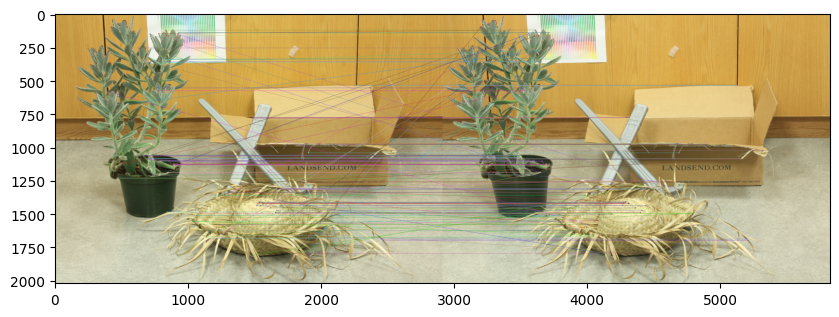

In [ ]:
# ASSIGNMENT #1b
# Detect and match keypoints
# Write your code here!
imagel=cv2.imread(images_path + 'iml_sword.png',0)
imager=cv2.imread(images_path + 'imr_sword.png',0)
# Initiate STAR detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp_l = orb.detect(imagel,None)
kp_r = orb.detect(imager,None)
# compute the descriptors with ORB
kp_l, des_l = orb.compute(imagel, kp_l)
kp_r, des_r = orb.compute(imager, kp_r)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_l, des_r)
matches = sorted(matches, key=lambda x:x.distance)

outImg = np.copy(imagel)
outImg = cv2.drawMatches(image_RGB1, kp_l, image_RGB2, kp_r, matches, outImg)
plt.figure()
plt.imshow(outImg)

### **<font color="green">ASSIGNMENT #1c</font>**

Now, refine the set of matched points in order to remove the outliers! For that, we are using the restriction of the **corresponding points lying on the same *row* coordinate** (with a certain threshold, remember that the configuration is not exactly ideal!). Use a certain threshold $th$ (e.g. $|v_l-v_r| < th$) to keep just those matches that fulfill the restriction. You can also define a **range of disparity** to be taken into account.

Once you have filtered your matches, obtain their 3D coordinates by applying **triangulation** as explained above. For this, you will need the intrinsic and extrinsic parameters of the stereo pair or cameras.

- If you calibrated your camera in the last notebook, **use such parameters and the same camera**. If you stored your calibration matrix as an `.npy` file, load it using [np.load](https://numpy.org/doc/stable/reference/generated/numpy.load.html). Otherwise, just create your calibration matrix as a `np.array` or recover your intrisinc parameters values from the previous notebook. <font color="orange">**Note**: if possible, disable your camera auto-focus setting when capturing images for calibration or this exercise, as it changes the intrinsic parameters of the camera for different images.</font>


- If you did not calibrate your camera, don't worry! **You can use these two sets of images and parameters** we provide to you in this notebook:
<table>
<tr>
    <td>iml_sword.png</td>    
    <td>imr_sword.png</td>    
    <td>parameters</td>    
</tr>    
<tr>
    <td><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/iml_sword.png" width="300"/></td>    
    <td><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/imr_sword.png" width="300"/></td>    
    <td>
      <b>K_l = K_r = </b> \begin{bmatrix} 687.2874 & 0 & 1329.49 \\ 0 & 687.2874 & 954.485 \\ 0 & 0 & 1 \end{bmatrix}
      <b>baseline = 17.47 cm </b>      
    </td>
</tr>    
<tr>
    <td>iml_lamp.tif</td>    
    <td>imr_lamp.tif</td>    
    <td>parameters</td>    
</tr>    
<tr>
    <td><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/iml_lamp.png" width="300"/></td>    
    <td><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/imr_lamp.png" width="300"/></td>    
    <td>
      <b>K_l = K_r = </b> \begin{bmatrix} 351.32 & 0 & 255.64 \\ 0 & 351.32 & 201.12 \\ 0 & 0 & 1 \end{bmatrix}
      <b>baseline = 11.9 cm </b>
    </td>
</tr>    
</table>


**What do you have to do?** Show the images and draw on them the filtered matches (you can use [cv2.circle](https://docs.opencv.org/4.2.0/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670)). Also, perform triangulation in order to get a list of the 3D coordinates of such points. Save the colors of the 3D points as well.

<ipython-input-5-1037c5e1c121>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imageCircles = cv2.circle(imagel,(np.int(kp_l[idx_l].pt[0]), np.int(kp_l[idx_l].pt[1])), 25, (255, 0, 0))


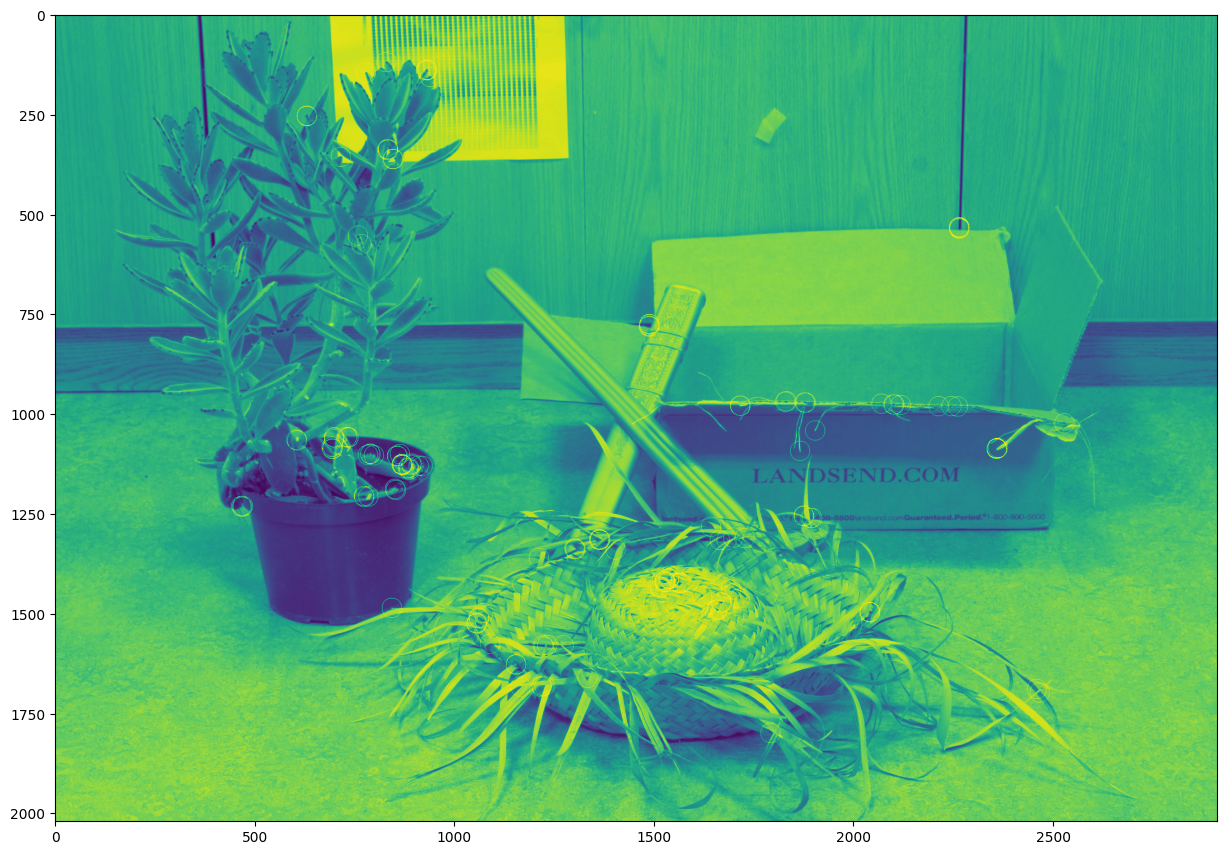

In [ ]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

# ASSIGNMENT 1c
# Write your code here!
# we assume kx/ky=1

# ...

# Define auxiliar data structures
# points3D = []
# color3D  = []

# Add the 3D point and the color of those matches that fulfill the requirements with 'points3D.append(...), ...'
kl = kr = np.array([[6872.874, 0, 1329.49],[0, 6872.874, 954.485],[0, 0, 1]])
b = 17.4724
f = 687.2874

robust_matches = []
points_3D = np.zeros((3,1))
threshold = 50

for n in range(len(matches)):
    idx_l = matches[n].queryIdx
    idx_r = matches[n].trainIdx
    fil_l = kp_l[idx_l].pt[1]
    fil_r = kp_r[idx_r].pt[1]
    if (abs(fil_l - fil_r) < threshold):
        robust_matches.append(matches[n])
        d = abs(kp_r[idx_r].pt[0] - kp_l[idx_l].pt[0])
        pt = (b/d)*np.asarray([[(kp_l[idx_l].pt[0] - kl[1,2])], [-(kp_l[idx_l].pt[1] - kl[0,2])], [f]])
        points_3D = np.hstack((points_3D,pt))
        imageCircles = cv2.circle(imagel,(np.int(kp_l[idx_l].pt[0]), np.int(kp_l[idx_l].pt[1])), 25, (255, 0, 0))
points_3D = points_3D[:,1:]
outImg = cv2.drawMatches(imagel, kp_l, imager, kp_r, robust_matches, np.array([]))
plt.figure()
plt.imshow(imageCircles)


####<font color=red><b>Expected output</b></font>

If you use the `SWORD` images, you should get something like this...
<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/expected_2d.png" width="1000" align="left"/>
</center>

### **<font color="green">ASSIGNMENT #1d</font>**

Once the 3D coordinates have been computed, the last step is **to show a 3D coloured scatter plot of the scene** using the data obtained in the previous step.

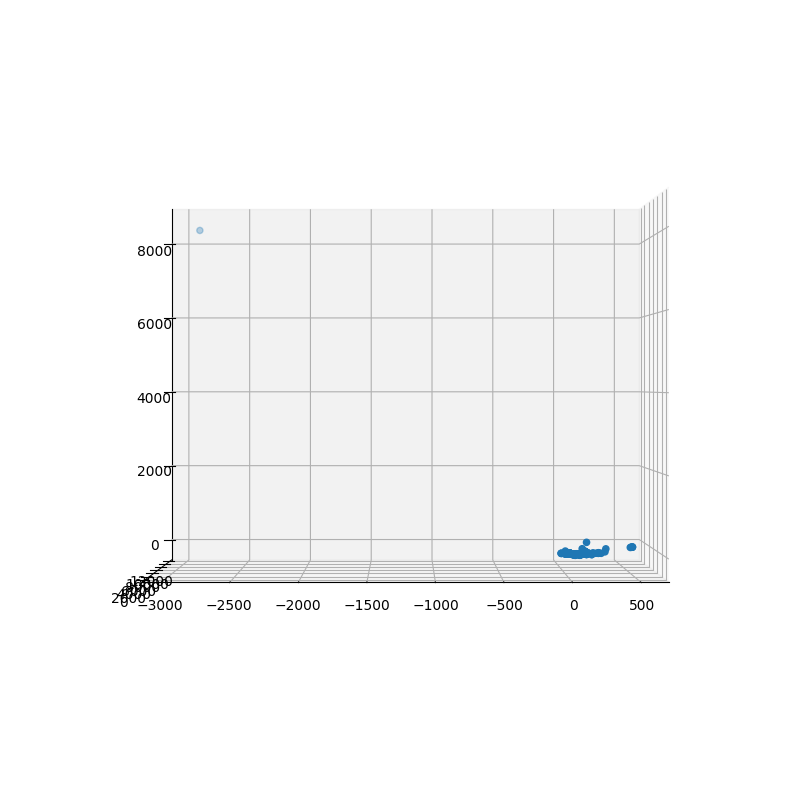

In [ ]:
# ASSIGNMENT #1d
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
# Write your code here!

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[0,:], points_3D[1,:], points_3D[2,:])
#ax.set_xlim3d(0,5000)
#ax.set_ylim3d(-2000,3000)
#ax.set_zlim3d(0,35000)
ax.view_init(elev=-0, azim=-90)

plt.show()

####<font color=red><b>Expected output</b></font>

If you use the `SWORD` images, you should get something like this (two different views have been shown here).
<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch10/insert/ch101_a1d_result.png" width="900" align="left"/>
</center>

## **Conclusion**

Fantastic work! Note that the **3D reconstruction of the scene preserves the real coordinates** with respect to the stereo system position. The distance unit used is determined by the camera matrix (focal length may be in meters, centimeters, ...).

In this notebook you have learnt:

- how stereo reconstruction works
- triangulation over a pair of rectified images using an ideal stereo vision system
- constraints that can be applied to matching points for detecting errors

In practise, the images used in stereo vision systems **need to be rectified** before applying triangulation. This will be learnt in the next notebook.